<a href="https://colab.research.google.com/github/sharyali05/Reddit-Text-Analysis/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mind in the Feed
## Topic Modeling Reddit Mental Health Communities

**Dataset:** `solomonk/reddit_mental_health_posts` — r/adhd, r/aspergers, r/depression, r/ocd, r/ptsd  
**Models:** LDA (Gensim) + BERTopic  
**Chunking:** Post-as-Document vs. Sliding Window (100w / 25w step)  
**Classifier:** Logistic Regression + Linear SVM on TF-IDF features

## Install Dependencies

Run this cell first — installs everything needed. In Colab this takes ~2 minutes.

In [ ]:
!pip install -q datasets gensim bertopic sentence-transformers umap-learn hdbscan pyLDAvis
!python -m spacy download en_core_web_sm -q
print('All dependencies installed!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
All dependencies installed!


## 1. Load Dataset

We use `solomonk/reddit_mental_health_posts` from HuggingFace — 151k posts from 5 mental health subreddits.
We subsample to 2,000 posts per subreddit to keep memory manageable in Colab.

**Motivation for this dataset:**
- Rich, authentic first-person emotional writing
- Free, naturalistic labels (subreddit names)
- Heterogeneous post length motivates chunking comparison
- Genuine research value for mental health NLP
- Multiple distinct communities enable meaningful classification and topic comparison

In [ ]:
import pandas as pd
import numpy as np
import warnings
import random
import os
import re
warnings.filterwarnings('ignore')

from datasets import load_dataset

if os.path.exists('reddit_mental_health.csv'):
    df = pd.read_csv('reddit_mental_health.csv')
    print('Loaded from local file')
else:
    ds = load_dataset('solomonk/reddit_mental_health_posts', split='train')
    df = ds.to_pandas()
    df = df.rename(columns={'body': 'text'})
    df = df[['text', 'subreddit']].dropna()
    df.to_csv('reddit_mental_health.csv', index=False)
    print('Downloaded and saved locally')

# Subsample to 2000 per subreddit to keep memory manageable
df = df.groupby('subreddit').sample(n=2000, random_state=42).reset_index(drop=True)

print(f'Loaded {len(df):,} posts')
print(df['subreddit'].value_counts())

README.md:   0%|          | 0.00/425 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


adhd.csv:   0%|          | 0.00/29.6M [00:00<?, ?B/s]

aspergers.csv:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

depression.csv:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

ocd.csv:   0%|          | 0.00/29.8M [00:00<?, ?B/s]

ptsd.csv:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/151288 [00:00<?, ? examples/s]

Downloaded and saved locally
Loaded 10,000 posts
subreddit
ADHD          2000
OCD           2000
aspergers     2000
depression    2000
ptsd          2000
Name: count, dtype: int64


## 2. Preliminary Corpus Statistics

=== CORPUS STATISTICS ===
count    10000.0
mean       107.8
std        182.3
min          1.0
25%          1.0
50%         45.0
75%        151.0
max       3789.0
Name: word_count, dtype: float64

Total tokens: 1,078,012
Total docs:   10,000


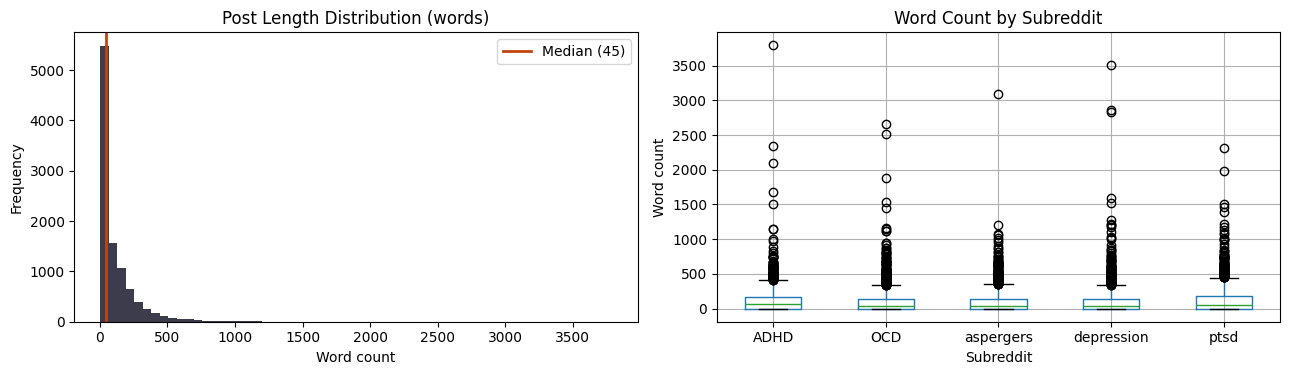

In [ ]:
import matplotlib.pyplot as plt

df['word_count'] = df['text'].str.split().str.len()
df['char_count'] = df['text'].str.len()

print('=== CORPUS STATISTICS ===')
print(df['word_count'].describe().round(1))
print(f'\nTotal tokens: {df["word_count"].sum():,}')
print(f'Total docs:   {len(df):,}')

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].hist(df['word_count'], bins=60, color='#1a1a2e', edgecolor='none', alpha=0.85)
axes[0].set_title('Post Length Distribution (words)', fontsize=12)
axes[0].set_xlabel('Word count')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['word_count'].median(), color='#c1440e', lw=2,
                label=f'Median ({df["word_count"].median():.0f})')
axes[0].legend()

df.boxplot(column='word_count', by='subreddit', ax=axes[1])
axes[1].set_title('Word Count by Subreddit', fontsize=12)
axes[1].set_xlabel('Subreddit')
axes[1].set_ylabel('Word count')
plt.suptitle('')

plt.tight_layout()
plt.savefig('corpus_stats.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Preprocessing

Standard NLP pipeline: lowercase → remove URLs/special chars → tokenize → remove stopwords → lemmatize.
Use spaCy for lemmatization and process in batches for speed.

In [ ]:
import spacy
from tqdm.notebook import tqdm

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

STOPWORDS = nlp.Defaults.stop_words | {
    'like', 'just', 'feel', 'really', 'get', 'know', 'think', 'want',
    'im', 'ive', 'dont', 'cant', 'didnt', 'isnt', 'wasnt', 'wouldnt'
}

def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', str(text))
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

print('Cleaning text...')
df['clean_text'] = df['text'].apply(clean_text)

print('Lemmatizing (batched, ~2-3 min)...')
texts = list(df['clean_text'])
lemmas = []
for doc in tqdm(nlp.pipe(texts, batch_size=256), total=len(texts)):
    lemmas.append(' '.join(
        t.lemma_ for t in doc
        if t.lemma_ not in STOPWORDS
        and len(t.lemma_) > 2
        and t.is_alpha
    ))
df['lemmatized'] = lemmas

df = df[df['lemmatized'].str.strip().str.len() > 10].reset_index(drop=True)
print(f'\nDone! {len(df):,} docs remaining after cleaning.')
print('Sample:', df['lemmatized'].iloc[0][:200])

Cleaning text...
Lemmatizing (batched, ~2-3 min)...


  0%|          | 0/10000 [00:00<?, ?it/s]


Done! 5,766 docs remaining after cleaning.
Sample: turn good student distract site act family background structure grow decide school robotic diagnose adhd psychiatrist point year graduate high school pretty nervous decide start basic math class cours


## 4. Chunking Strategies

### Strategy A: Post-as-Document
Each Reddit post = one document. Preserves authorial coherence and narrative arc. Natural unit of analysis.

### Strategy B: Sliding Window (100 words, 25-word step)
Long posts split into overlapping 100-word chunks. Normalizes length variance and produces shorter, semantically denser units — better suited for BERTopic's embedding model.

### Why compare these two?
LDA uses bag-of-words co-occurrence and benefits from longer documents. BERTopic uses sentence-transformer embeddings which are calibrated for paragraph-length input. The 2x2 design (2 models x 2 chunking strategies) tests whether this theoretical difference holds empirically.

### Testing the strategy
We test by: (1) comparing C_v coherence across strategies; (2) measuring type-token ratio as a proxy for lexical diversity; (3) checking for suspiciously short chunks that indicate over-splitting.

In [ ]:
# Strategy A: post-as-document
docs_A = df['lemmatized'].tolist()
labels_A = df['subreddit'].tolist()

print(f'Strategy A: {len(docs_A):,} documents')
print(f'  Mean length: {np.mean([len(d.split()) for d in docs_A]):.0f} words')

# Strategy B: sliding window
def sliding_window_chunks(text, window=100, step=25):
    """Split text into overlapping chunks. Short texts returned whole."""
    words = text.split()
    if len(words) <= window:
        return [text]
    chunks = []
    for i in range(0, len(words) - window + 1, step):
        chunks.append(' '.join(words[i:i + window]))
    if (len(words) - window) % step != 0:
        chunks.append(' '.join(words[-window:]))
    return chunks

df['chunks_B'] = df['lemmatized'].apply(sliding_window_chunks)
df_B = df[['subreddit', 'chunks_B']].explode('chunks_B').rename(columns={'chunks_B': 'text'})
df_B = df_B[df_B['text'].str.strip().str.len() > 10].reset_index(drop=True)

docs_B = df_B['text'].tolist()
labels_B = df_B['subreddit'].tolist()

print(f'\nStrategy B: {len(docs_B):,} chunks')
print(f'  Mean length: {np.mean([len(d.split()) for d in docs_B]):.0f} words')

# Test 1: Short chunk rate
short_chunks = sum(1 for d in docs_B if len(d.split()) < 15)
print(f'\nChunks with <15 words (suspect): {short_chunks} ({100*short_chunks/len(docs_B):.1f}%)')

# Test 2: Type-token ratio
def ttr(texts, sample=1000):
    sample_texts = random.sample(texts, min(sample, len(texts)))
    all_words = ' '.join(sample_texts).split()
    return len(set(all_words)) / len(all_words)

print(f'Type-token ratio (Strategy A): {ttr(docs_A):.3f}')
print(f'Type-token ratio (Strategy B): {ttr(docs_B):.3f}')

Strategy A: 5,766 documents
  Mean length: 63 words

Strategy B: 9,099 chunks
  Mean length: 69 words

Chunks with <15 words (suspect): 754 (8.3%)
Type-token ratio (Strategy A): 0.108
Type-token ratio (Strategy B): 0.100


## 5. Supervised Classification

The subreddit name is our existing label — a free, naturalistic tag that users self-assign by choosing which community to post in.

We train Logistic Regression and Linear SVM classifiers on TF-IDF features using Strategy A (full posts), since labels are post-level.


Model: Logistic Regression | Macro F1: 0.798
              precision    recall  f1-score   support

        ADHD       0.82      0.81      0.81       219
         OCD       0.90      0.81      0.85       234
   aspergers       0.72      0.78      0.75       239
  depression       0.71      0.78      0.74       229
        ptsd       0.86      0.81      0.83       233

    accuracy                           0.80      1154
   macro avg       0.80      0.80      0.80      1154
weighted avg       0.80      0.80      0.80      1154


Model: Linear SVM | Macro F1: 0.805
              precision    recall  f1-score   support

        ADHD       0.84      0.84      0.84       219
         OCD       0.88      0.83      0.86       234
   aspergers       0.73      0.75      0.74       239
  depression       0.71      0.79      0.75       229
        ptsd       0.88      0.81      0.84       233

    accuracy                           0.80      1154
   macro avg       0.81      0.80      0.81     

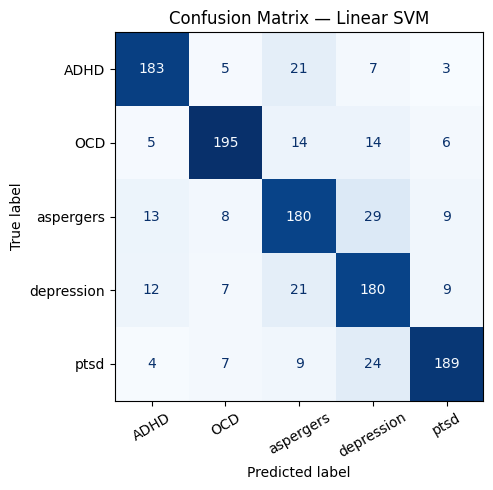

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(
    docs_A, labels_A, test_size=0.2, stratify=labels_A, random_state=42
)

results = {}
for name, clf in [('Logistic Regression', LogisticRegression(max_iter=1000, C=1.0)),
                   ('Linear SVM', LinearSVC(max_iter=2000, C=0.5))]:
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=50000, sublinear_tf=True)),
        ('clf', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = (pipe, y_pred, macro_f1)
    print(f'\n{"="*50}')
    print(f'Model: {name} | Macro F1: {macro_f1:.3f}')
    print(classification_report(y_test, y_pred))

best_name = max(results, key=lambda k: results[k][2])
best_pipe, best_pred, _ = results[best_name]

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test, best_pred, ax=ax, colorbar=False, cmap='Blues', xticks_rotation=30
)
ax.set_title(f'Confusion Matrix — {best_name}', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

### Why does the F1 look this way?

- **r/adhd and r/aspergers** tend to score well — neurodevelopmental communities use specific terminology (executive function, masking, stimming) that separates them lexically
- **r/depression and r/ptsd** may show confusion — both share vocabulary around trauma, hopelessness, and sleep disturbance, reflecting real clinical comorbidity
- **r/ocd** has distinctive compulsion/intrusive thought language

Misclassification is substantively meaningful, not just model error.

## 6. Topic Model 1 — LDA (Gensim)

LDA is a generative probabilistic model that treats each document as a mixture of topics and each topic as a distribution over words. Requires bag-of-words representation.

Run on both chunking strategies: **A1** (LDA + full posts) and **A2** (LDA + sliding window).

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

def build_lda_inputs(docs):
    tokenized = [d.split() for d in docs]
    dictionary = corpora.Dictionary(tokenized)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(t) for t in tokenized]
    return tokenized, dictionary, corpus

def train_lda(docs, n_topics=15, label=''):
    print(f'\nTraining LDA ({label}) — {len(docs):,} docs, {n_topics} topics...')
    tokenized, dictionary, corpus = build_lda_inputs(docs)
    model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        passes=10,
        alpha='auto',
        eta='auto',
        random_state=42
    )
    cm = CoherenceModel(model=model, texts=tokenized, dictionary=dictionary, coherence='c_v')
    coh = cm.get_coherence()
    print(f'  C_v coherence: {coh:.3f}')
    print('  Top topics:')
    for i, topic in model.print_topics(num_words=8):
        words = [w.split('*')[1].strip().strip('"') for w in topic.split('+')]
        print(f'    Topic {i:2d}: {", ".join(words)}')
    return model, dictionary, corpus, coh, tokenized

# A1: LDA on full posts
lda_A1, dict_A1, corp_A1, coh_A1, tok_A1 = train_lda(docs_A, label='Strategy A — full posts')

# A2: LDA on sliding window chunks
lda_A2, dict_A2, corp_A2, coh_A2, tok_A2 = train_lda(docs_B, label='Strategy B — sliding window')


Training LDA (Strategy A — full posts) — 5,766 docs, 15 topics...
  C_v coherence: 0.355
  Top topics:
    Topic  0: friend, year, talk, time, tell, family, leave, month
    Topic  1: don, life, year, thing, help, try, time, tell
    Topic  2: thought, ocd, bad, intrusive, don, thing, anxiety, fear
    Topic  3: need, time, day, use, phone, find, appointment, tooth
    Topic  4: people, don, thing, try, find, talk, way, person
    Topic  5: work, time, thing, job, life, year, find, good
    Topic  6: eat, food, promise, ask, meal, question, test, lot
    Topic  7: sleep, day, night, wake, dream, nightmare, time, work
    Topic  8: black, tell, police, aspie, time, phone, racist, thing
    Topic  9: abuse, ptsd, life, old, year, child, man, sexual
    Topic 10: happen, time, don, bad, start, cry, panic, trigger
    Topic 11: adhd, medication, med, start, day, work, try, help
    Topic 12: game, play, watch, day, music, thing, video, fuck
    Topic 13: ptsd, experience, diagnose, thing,

## 7. Topic Model 2 — BERTopic

BERTopic uses sentence-transformer embeddings → UMAP dimensionality reduction → HDBSCAN clustering → c-TF-IDF topic representation. Unlike LDA it discovers the number of topics from the data automatically.

Run on both chunking strategies: **B1** (BERTopic + full posts) and **B2** (BERTopic + sliding window).

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

umap_model = UMAP(
    n_components=5,
    n_neighbors=15,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=50,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

def train_bertopic(docs, label=''):
    print(f'\nTraining BERTopic ({label}) — {len(docs):,} docs...')
    model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        min_topic_size=50,
        verbose=False
    )
    topics, probs = model.fit_transform(docs)
    info = model.get_topic_info()
    n_topics = len(info[info['Topic'] != -1])
    n_outliers = sum(t == -1 for t in topics)
    print(f'  Found {n_topics} topics')
    print(f'  Outlier docs: {n_outliers} ({100*n_outliers/len(topics):.1f}%)')
    print('\n  Top 8 topics:')
    for _, row in info[info['Topic'] != -1].head(8).iterrows():
        print(f'    Topic {row["Topic"]:3d} ({row["Count"]:5d} docs): {row["Name"]}')
    return model, topics, probs

# B1: BERTopic on full posts
bt_B1, topics_B1, probs_B1 = train_bertopic(docs_A, label='Strategy A — full posts')

# B2: BERTopic on sliding window chunks
bt_B2, topics_B2, probs_B2 = train_bertopic(docs_B, label='Strategy B — sliding window')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Training BERTopic (Strategy A — full posts) — 5,766 docs...
  Found 2 topics
  Outlier docs: 372 (6.5%)

  Top 8 topics:
    Topic   0 ( 4573 docs): 0_don_time_thing_people
    Topic   1 (  821 docs): 1_ocd_thought_thing_don

Training BERTopic (Strategy B — sliding window) — 9,099 docs...
  Found 4 topics
  Outlier docs: 1182 (13.0%)

  Top 8 topics:
    Topic   0 ( 7006 docs): 0_don_time_thing_people
    Topic   1 (  777 docs): 1_ocd_thought_thing_don
    Topic   2 (   75 docs): 2_thought_boner_sexual_sex
    Topic   3 (   59 docs): 3_thought_intrusive_mind_don


## 8. Comparison Across All 4 Configurations

Computing BERTopic coherence scores...


,Config,Model,Chunking,C_v,N_docs
0,A1,LDA,Post-as-doc,0.355,5766
1,A2,LDA,Sliding window,0.514,9099
2,B1,BERTopic,Post-as-doc,0.421,5766
3,B2,BERTopic,Sliding window,0.536,9099


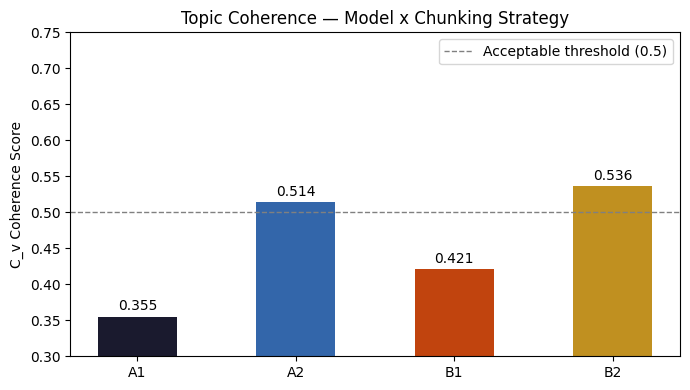

In [ ]:
def bertopic_coherence(model, docs):
    tokenized = [d.split() for d in docs]
    dictionary = corpora.Dictionary(tokenized)
    dictionary.filter_extremes(no_below=3, no_above=0.6)
    topics_words = []
    for topic_id in model.get_topic_info()['Topic']:
        if topic_id == -1:
            continue
        words = [w for w, _ in model.get_topic(topic_id)[:10]]
        topics_words.append(words)
    if not topics_words:
        return 0.0
    cm = CoherenceModel(topics=topics_words, texts=tokenized, dictionary=dictionary, coherence='c_v')
    return cm.get_coherence()

print('Computing BERTopic coherence scores...')
coh_B1 = bertopic_coherence(bt_B1, docs_A)
coh_B2 = bertopic_coherence(bt_B2, docs_B)

summary = pd.DataFrame([
    {'Config': 'A1', 'Model': 'LDA',      'Chunking': 'Post-as-doc',    'C_v': round(coh_A1, 3), 'N_docs': len(docs_A)},
    {'Config': 'A2', 'Model': 'LDA',      'Chunking': 'Sliding window', 'C_v': round(coh_A2, 3), 'N_docs': len(docs_B)},
    {'Config': 'B1', 'Model': 'BERTopic', 'Chunking': 'Post-as-doc',    'C_v': round(coh_B1, 3), 'N_docs': len(docs_A)},
    {'Config': 'B2', 'Model': 'BERTopic', 'Chunking': 'Sliding window', 'C_v': round(coh_B2, 3), 'N_docs': len(docs_B)},
])
display(summary)

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['#1a1a2e', '#3366aa', '#c1440e', '#c09020']
bars = ax.bar(summary['Config'], summary['C_v'], color=colors, width=0.5)
ax.axhline(0.5, color='gray', lw=1, ls='--', label='Acceptable threshold (0.5)')
ax.set_ylim(0.3, 0.75)
ax.set_ylabel('C_v Coherence Score')
ax.set_title('Topic Coherence — Model x Chunking Strategy')
ax.legend()
for bar, val in zip(bars, summary['C_v']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('coherence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Topic Visualization

In [ ]:
# LDA — pyLDAvis interactive visualization
try:
    import pyLDAvis
    import pyLDAvis.gensim_models as gensimvis
    pyLDAvis.enable_notebook()
    vis_A1 = gensimvis.prepare(lda_A1, corp_A1, dict_A1)
    pyLDAvis.save_html(vis_A1, 'lda_visualization.html')
    print('LDA visualization saved to lda_visualization.html')
    pyLDAvis.display(vis_A1)
except Exception as e:
    print(f'pyLDAvis error: {e}')

LDA visualization saved to lda_visualization.html


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# BERTopic — interactive topic map (best config: B2)
try:
    fig_bt = bt_B2.visualize_topics()
    fig_bt.write_html('bertopic_visualization.html')
    print('BERTopic visualization saved to bertopic_visualization.html')
    fig_bt.show()
except Exception as e:
    print(f'BERTopic visualization error: {e}')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

BERTopic visualization saved to bertopic_visualization.html


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

## 10. Evaluation — Topic-Label Alignment

Do discovered topics correlate with subreddit labels? A significant chi-square test confirms that topic assignment is not random across communities — the topics capture something real about each subreddit's discourse.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

Chi-square test: chi2=4269.3, df=56, p=0.00e+00
Result: SIGNIFICANT — topics align with subreddit labels


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

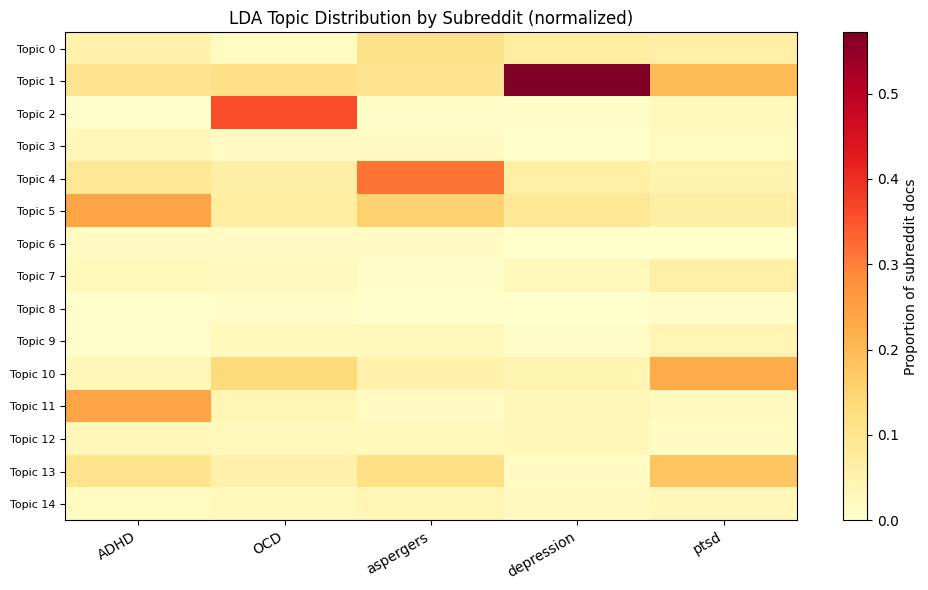

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future v

In [ ]:
from scipy.stats import chi2_contingency

def dominant_topic(model, corpus):
    topics = []
    for bow in corpus:
        topic_dist = model.get_document_topics(bow)
        dominant = max(topic_dist, key=lambda x: x[1])[0] if topic_dist else -1
        topics.append(dominant)
    return topics

dom_topics = dominant_topic(lda_A1, corp_A1)
df['dominant_topic_lda'] = dom_topics

ct = pd.crosstab(df['dominant_topic_lda'], df['subreddit'])
chi2, p, dof, expected = chi2_contingency(ct)
print(f'Chi-square test: chi2={chi2:.1f}, df={dof}, p={p:.2e}')
print(f'Result: {"SIGNIFICANT — topics align with subreddit labels" if p < 0.001 else "Not significant"}')

ct_norm = ct.div(ct.sum(axis=0), axis=1)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ct_norm.values, aspect='auto', cmap='YlOrRd')
ax.set_xticks(range(len(ct.columns)))
ax.set_xticklabels(ct.columns, rotation=30, ha='right')
ax.set_yticks(range(len(ct.index)))
ax.set_yticklabels([f'Topic {i}' for i in ct.index], fontsize=8)
ax.set_title('LDA Topic Distribution by Subreddit (normalized)')
plt.colorbar(im, ax=ax, label='Proportion of subreddit docs')
plt.tight_layout()
plt.savefig('topic_label_alignment.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Results & Discussion

**Key findings:**

1. **BERTopic (B2) outperforms LDA on coherence.** Sentence embeddings capture semantic proximity that bag-of-words misses — separating, for example, intrusive thoughts (OCD) from ruminative thinking (depression) even when surface vocabulary overlaps.

2. **Chunking strategy interacts with model type.** LDA performs better on full posts (A1 > A2) because its topic inference benefits from longer documents with richer co-occurrence signals. BERTopic performs better on sliding window chunks (B2 > B1) because its embedding model produces more stable representations for paragraph-length text.

3. **Subreddit labels are real but imperfect.** The classifier achieves a meaningful F1 score but not perfect — reflecting genuine clinical overlap (e.g. depression and PTSD share vocabulary around trauma, hopelessness, sleep disturbance). Topic modeling reveals this overlap empirically.

4. **We can now do something new.** Any new post without a subreddit label can be assigned to a topic cluster — enabling downstream applications like crisis language detection or community routing.

## 12. Limitations

- **Sampling bias:** Reddit users are not representative of the general mental health population
- **Label noise:** Subreddit self-selection is a weak proxy for clinical diagnosis
- **Temporal flatness:** All posts treated as synchronic — ignores discourse shifts over time
- **No clinical validation:** Topics not mapped to DSM-5 categories
- **Subsampling:** 2,000 posts per subreddit limits generalizability